In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests

In [130]:
%matplotlib inline

In [131]:
url = 'https://pomber.github.io/covid19/timeseries.json'
filedata = requests.get(url)
data = json.loads(filedata.content)

In [132]:
df = pd.DataFrame()
df['date'] = [m['date'] for m in data['Germany']]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df['de'] = [m['confirmed'] for m in data['Germany']]
df['de/dt'] = np.gradient(df.get('de','confirmed'))
df['de/dt2'] = np.gradient(df.get('de/dt','confirmed'))
df['de-rem'] = [m['recovered'] for m in data['Germany']]
df['de-abs'] = df['de'] - df['de-rem']
#df['fr'] = [m['confirmed'] for m in data['France']]
#df['fr/dt'] = np.gradient(df.get('fr','confirmed'))
#df['fr/dt2'] = np.gradient(df.get('fr/dt','confirmed'))
#df['it'] = [m['confirmed'] for m in data['Italy']]
#df['it/dt'] = np.gradient(df.get('it','confirmed'))
#df['it/dt2'] = np.gradient(df.get('it/dt','confirmed'))
#df['it-rem'] = [m['recovered'] for m in data['Italy']]
#df['it-abs'] = df['it'] - df['it-rem']
#df['ph'] = [m['confirmed'] for m in data['Philippines']]
#df['ph/dt'] = np.gradient(df.get('ph','confirmed'))
#df['ph/dt2'] = np.gradient(df.get('ph/dt','confirmed'))
#df['us'] = [m['confirmed'] for m in data['US']]
#df['us/dt'] = np.gradient(df.get('us','confirmed'))
#df['us/dt2'] = np.gradient(df.get('us/dt','confirmed'))
#df['us-rem'] = [m['recovered'] for m in data['US']]
#df['us-abs'] = df['us'] - df['us-rem']

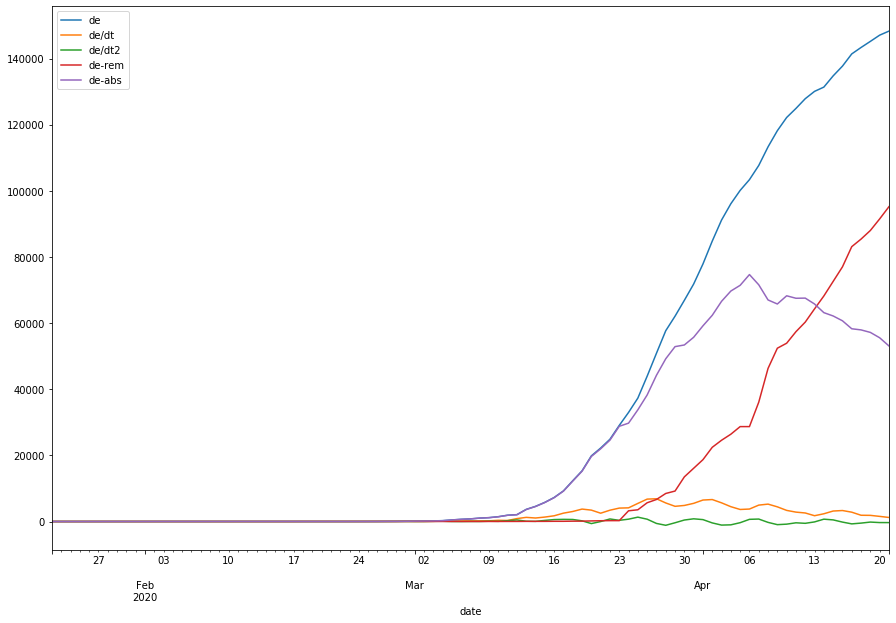

In [133]:
df.plot(figsize=(15,10))

In [134]:
print("Total cases [de]: ", df['de'][-1])
print("New cases rate [de]: ", df['de/dt'][-1])
print("New cases rate change [de]: ", df['de/dt2'][-1])
print("Recovered cases [de]: ", df['de-rem'][-1])
print("Active cases [de]: ", df['de-abs'][-1])

Total cases [de]:  148291
New cases rate [de]:  1226.0
New cases rate change [de]:  -327.5
Recovered cases [de]:  95200
Active cases [de]:  53091


In [135]:
intensive_care_capacity = 30000
intensive_care_factor = 1/100
infection_duration_days = 21

N_de = 83019213
I_de = df['de-abs'][-1]
R_de = df['de-rem'][-1]

beta_de = df['de/dt'][-1] / df['de-abs'][-1]

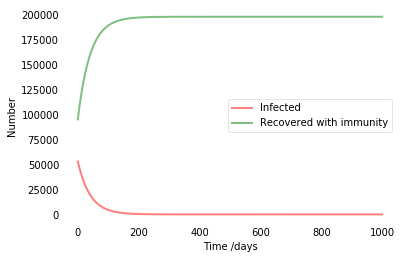

In [139]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = N_de
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = I_de, R_de
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = beta_de, 1./infection_duration_days
# A grid of time points (in days)
t = np.linspace(0, 1000, 1000)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (91,)

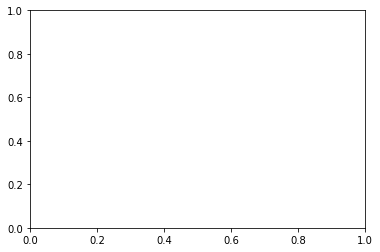

In [142]:
df['abs-ext'] = df['de-abs'].append(pd.Series(I))
df['rem-ext'] = df['de-rem'].append(pd.Series(R))

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, df['abs-ext'], 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, df['rem-ext'], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.show()